# Structured Bayesian Optimisation with Pyro

Goal: apply Structured Bayesian Optimisation (BO) strategy to minimize Branin-Hoo function with pyro.

Based on: 
- branin_hoo_pyro_semiparam_brooks.ipynb
- branin_hoo_pyro_bo.ipynb

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.autograd as autograd

# Objective function

In [2]:
const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

def branin_hoo(x):
    """ Compute Branin-Hoo function for fixed constants """
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    x1 = x[...,0]
    x2 = x[...,1]
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

In [3]:
def plot_function(f, n_points=100):
    XX, YY = np.meshgrid(np.linspace(-5, 10, n_points), np.linspace(0, 15, n_points))
    ZZ = f(torch.FloatTensor(np.stack([XX.ravel(), YY.ravel()]).T))
    plt.imshow(ZZ.reshape(n_points, n_points));
    plt.xticks(np.linspace(0, n_points, 6), np.linspace(-5, 10, 6))
    plt.yticks(np.linspace(0, n_points, 6), np.linspace(0, 15, 6))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.set_cmap('jet')
    plt.colorbar()
    plt.gca().invert_yaxis()

# Initial (train) data

Generating random training points

In [4]:
torch.random.manual_seed(555)

N_points = 10
X = torch.rand(N_points, 2)*15 + torch.FloatTensor([-5, 0])
y = branin_hoo(X)

# Parametric model in pyro

In [5]:
def parametric_fn(X, alpha, beta, gamma):
    x1 = X[...,0]
    x2 = X[...,1]
    return alpha * torch.cos(x1) + beta*torch.pow(x1, 4) + torch.pow(x2, 2) + gamma

# Semi parametric model as implemented by Brooks

In [6]:
pyro.clear_param_store()

class SemiParametricModel(nn.Module):

    def __init__(self, X, y):
        super().__init__()
        
        # Store data
        D = X.shape[-1]
        self.X = X
        self.y = y
        
        # Define parameters for parametric model
        # TODO: I couldn't figure out how to do this using `pyro.param`, so instead
        #       I am using `nn.Parameter`. This is annoying, because now constraints
        #       need to be handled manually, using the properties below
        self._mu_a = nn.Parameter(torch.zeros(1))
        self._mu_b = nn.Parameter(torch.zeros(1))
        self._mu_c = nn.Parameter(torch.zeros(1))
        self._sd_a = nn.Parameter(torch.zeros(1))
        self._sd_b = nn.Parameter(torch.zeros(1))
        self._sd_c = nn.Parameter(torch.zeros(1))
        
        self._mu_transform = transform_to(constraints.interval(0, 20))
        self._sd_transform = transform_to(constraints.positive)

        # Define GP regressor (leave the data arguments empty for now)
        self.gp = gp.models.GPRegression(torch.empty((0, D)), torch.empty((0,)),
                                         kernel=gp.kernels.Matern52(input_dim=D, lengthscale=torch.ones(D)))

        # Set priors for GP (these are the values used in the semiparametric BOAT model, which assumes noiseless GP)
        self.gp.kernel.set_prior("lengthscale", dist.LogNormal(0.0, 15.0))
        self.gp.kernel.set_prior("variance", dist.Uniform(0.0, 20.0))
        self.gp.set_prior("noise", dist.Uniform(0.0, 1.0))

        # Set guides for GP
        self.gp.kernel.autoguide("lengthscale", dist.Normal)
        self.gp.kernel.autoguide("variance", dist.Normal)
        self.gp.autoguide("noise", dist.Normal)
    
    @property
    def mu_a(self): return self._mu_transform(self._mu_a)

    @property
    def mu_b(self): return self._mu_transform(self._mu_b)

    @property
    def mu_c(self): return self._mu_transform(self._mu_c)

    @property
    def sd_a(self): return self._sd_transform(self._sd_a)

    @property
    def sd_b(self): return self._sd_transform(self._sd_b)
    
    @property
    def sd_c(self): return self._sd_transform(self._sd_c)
    
    def guide(self):
        self.gp.guide()
        alpha = pyro.sample('alpha', dist.Normal(self.mu_a, self.sd_a))
        beta = pyro.sample('beta', dist.Normal(self.mu_b, self.sd_b))
        gamma = pyro.sample('gamma', dist.Normal(self.mu_c, self.sd_c))
        return alpha, beta, gamma

    def model(self):
        alpha = pyro.sample('alpha', dist.Uniform(0, 20))
        beta = pyro.sample('beta', dist.Uniform(0, 20))
        gamma = pyro.sample('gamma', dist.Uniform(0, 20))
        g = parametric_fn(self.X, alpha, beta, gamma)
        residual = self.y - g
        # update the GP to now model the residual from the parametric model
        self.gp.set_data(self.X, residual)
        # call GP model function to actually make the observation
        self.gp.model()
        
    def forward(self, X):
        g = parametric_fn(X, *self.guide())        
        mu, var = self.gp(X)
        return g + mu, var

semi_parametric = SemiParametricModel(X, y)

# Constructing SBO strategy

In [7]:
def train(num_steps=1000):
    
    param_opt = torch.optim.Adam(semi_parametric.parameters(recurse=False), lr=0.1)
    gp_opt = torch.optim.Adam(semi_parametric.gp.parameters(), lr=0.005)
    
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    
    losses = []
        
    for i in range(num_steps):
        gp_opt.zero_grad()
        param_opt.zero_grad()
        loss = loss_fn(semi_parametric.model, semi_parametric.guide)
        loss.backward()
        gp_opt.step()
        param_opt.step()
        losses.append(loss.item())
    
    return losses

### Defining acquisition function

In [8]:
def acquisition_func(x):
    kappa = 2.0
    
    mu, variance = semi_parametric(x)
        
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

### Function to find minimizing points for an acquisition function

In [9]:
def find_a_candidate(x_init):
    
    # Creating constrains
    constraint_x1 = constraints.interval(const_x1_min, const_x1_max)
    constraint_x2 = constraints.interval(const_x2_min, const_x2_max)
    
    # transform x_init to an unconstrained domain as we use an unconstrained optimizer
    unconstrained_x1_init = transform_to(constraint_x1).inv(x_init[:, 0])
    unconstrained_x2_init = transform_to(constraint_x2).inv(x_init[:, 1])
    x_uncon_init = torch.stack((unconstrained_x1_init, unconstrained_x2_init), dim=1)
    
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # unconstrained minimiser
    minimizer = optim.LBFGS([x_uncon])

    def closure():
        minimizer.zero_grad()
                
        x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
        x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
        x = torch.stack((x1_tmp, x2_tmp), dim=1)
        
        y = acquisition_func(x)
        
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))
                
        return y
    
    minimizer.step(closure)
   
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
    x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
    
    x = torch.stack((x1_tmp, x2_tmp), dim=1)
    
    return x.detach()

### A single step of SBO

In [10]:
def next_x(num_candidates=5):
    
    candidates = []
    values = []
    
    # take the last point as the first attempt
    x_init = semi_parametric.X[-1:]
    
    for i in range(num_candidates):
        
        x = find_a_candidate(x_init)
        y = acquisition_func(x)
    
        candidates.append(x)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    
    return candidates[argmin]

In [11]:
def plot_model():
    plt.figure(figsize=(12,3)) 
    
    # Acquisition function
    plt.subplot(1,4,1)
    plt.title("Acquisition")
    with torch.no_grad(): 
        plot_function(acquisition_func)

    # Losses
    plt.subplot(1,4,2)
    plt.title("Losses")
    plt.semilogy(losses);

    # Semi-param model mu
    plt.subplot(1,4,3)
    plt.title("Semi-param model $\mu$")
    with torch.no_grad(): 
        plot_function(lambda X: semi_parametric(X)[0])

    # Semi-param model sigma
    plt.subplot(1,4,4)
    plt.title("Semi-param model $\sigma$")
    with torch.no_grad(): 
        plot_function(lambda X: semi_parametric(X)[1])

    plt.tight_layout();

### Updating posterior

In [12]:
def update_posterior(x_new):
    
    # evaluate f at new point
    bh_y = branin_hoo(x_new) 
        
    # incorporate new evaluation
    semi_parametric.X = torch.cat([semi_parametric.X, x_new]) 
    semi_parametric.y = torch.cat([semi_parametric.y, bh_y])
    
    losses = train()
    
    plot_model()

# The SBO Algorithm

### The first step

In [13]:
losses = train()

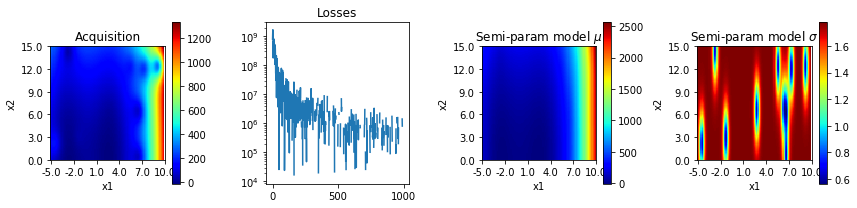

In [14]:
plot_model()

Step SBO:  1 new point:  tensor([[-2.7037e+00,  1.7693e-06]])
Step SBO:  2 new point:  tensor([[10.0000,  0.3994]])
Step SBO:  3 new point:  tensor([[1.0000e+01, 8.3979e-06]])
Step SBO:  4 new point:  tensor([[3.1373, 0.5621]])
Step SBO:  5 new point:  tensor([[9.0565, 2.9327]])
Step SBO:  6 new point:  tensor([[3.0826, 3.1709]])
Step SBO:  7 new point:  tensor([[3.1994, 2.4200]])
Step SBO:  8 new point:  tensor([[8.8171, 1.1655]])
Step SBO:  9 new point:  tensor([[9.4794, 2.7721]])
Step SBO:  10 new point:  tensor([[3.0144, 2.3205]])


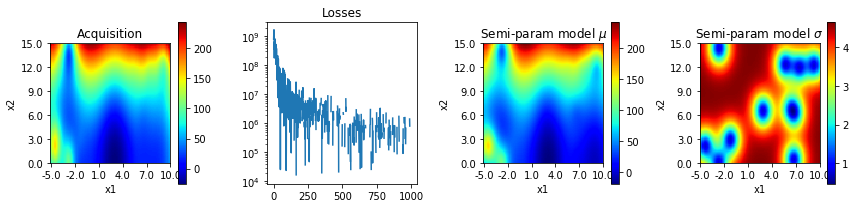

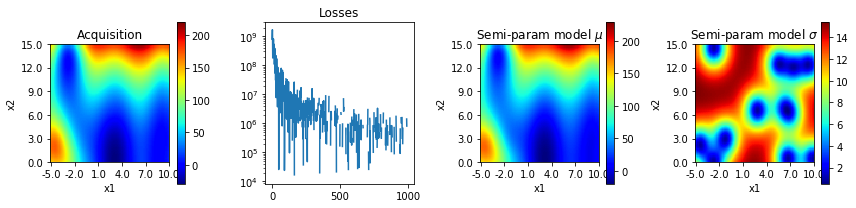

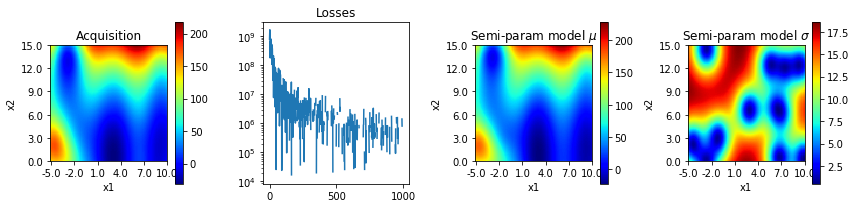

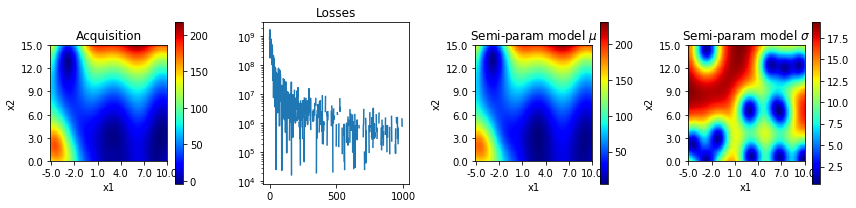

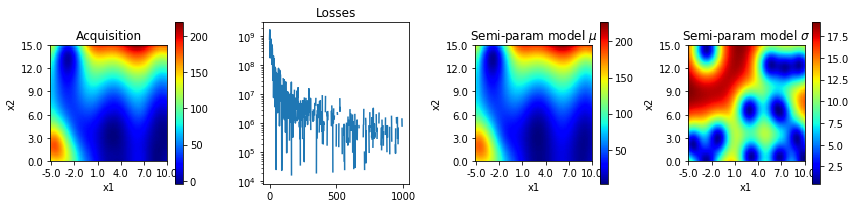

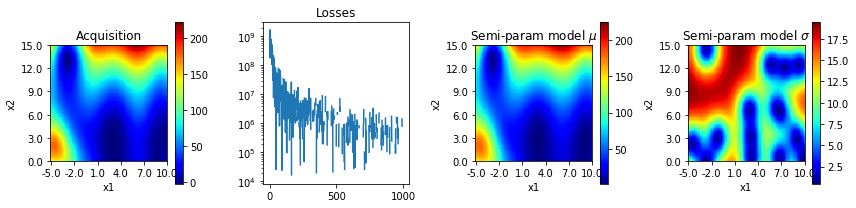

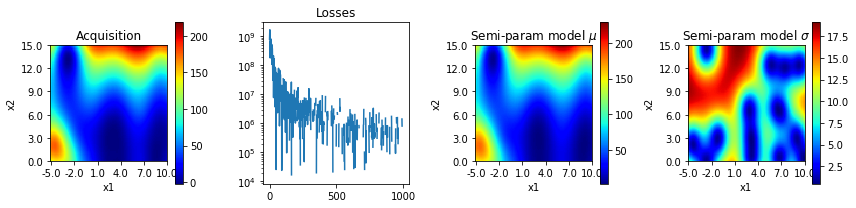

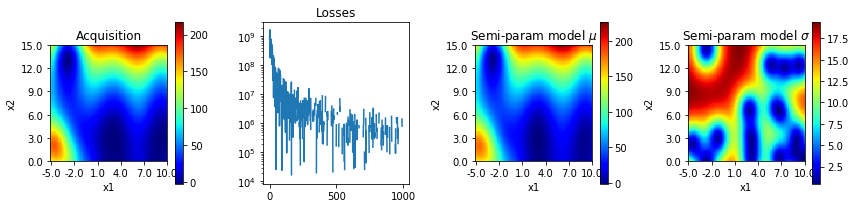

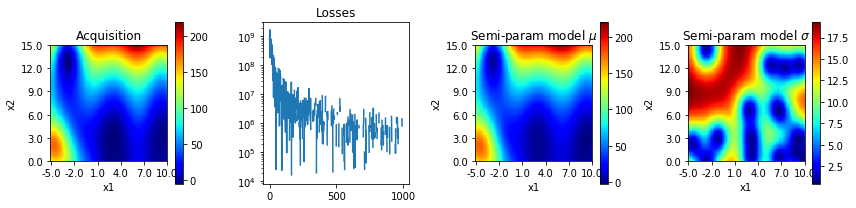

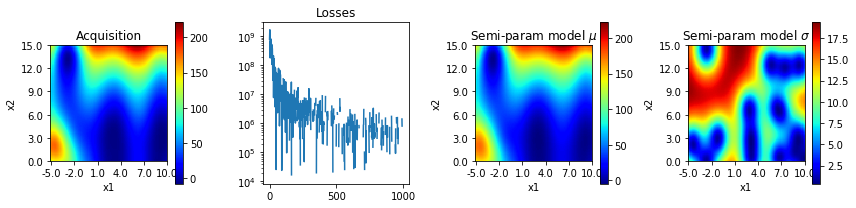

In [15]:
sbo_steps = 10

for i in range(sbo_steps):
    
    xmin = next_x()
    
    print("Step SBO: ", i+1, "new point: ", xmin)
    
    update_posterior(xmin)